# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [148]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [149]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [150]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

###### Para Regressão

In [151]:
def mae(y, y_pred, derivative=True):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y - y_pred))

def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    return 0.5 * np.mean((y - y_pred) ** 2)

###### Para Classificação Binária

In [152]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])
    return - np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=True):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return - np.mean(y * np.log(y_sigmoid) + (1 - y) * np.log(1 - y_sigmoid))

###### Para Classificação Multiclasse

In [153]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

# Inicialização de Pesos

# Regularização

# Batch Generator

# Learning Rate Decay

# Batch Normalization 

# Implementação 

In [154]:
# camada
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear):
        self.input = None
        self.weights = np.random.randn(output_dim, input_dim) # linhas x colunas (inicalizando de forma aleatória)
        self.biases = np.random.randn(1, output_dim) #output_dim = quantidade de neuronios da camada
        self.activation = activation
        
        # entrada e saída da função de ativação, usada nas derivadas
        self._activ_inp, self._activ_out = None, None
        
        # vars para armazenar a derivada em relacao aos pesos e em relacao aos bias
        self._dweights, self._dbiases = None, None

# rede
class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3):
        self.layers = [] # array de camas com objetos da classe Layer
        self.cost_func = cost_func
        self.learning_rate = learning_rate
    
    def fit(self, x_train, y_train, epochs=100, verbose=10): #verbose = mostrar a função de custo
        for epoch in range(epochs + 1):
            y_pred = self.__feedforward(x_train)
            self.__backprop(y_train, y_pred)
            
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                print("epoch: {0:=4}/{1}. loss_train: {2:.8f}".format(epoch, epochs, loss_train))
    
    def predict(self, x):
        return self.__feedforward(x) #passando as amostrar no feed forward
    
    def __feedforward(self, x): # deixando "nao acessivel" com o "__"
        self.layers[0].input = x # entrada da primeira camada, os dados
        
        # loop para acessar a camada atual e a próxima, para calcular a função de ativação 
        for current_layer, next_layer in zip (self.layers, self.layers[1:] + [Layer(0, 0)]): 
            # adicionando um layer com a camada vazia para os dois arrays terem o msm tamanho e a
            #current_layer acessar a ultima camada
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self.layers[-1]._activ_out
    
    
    def __backprop(self, y, y_pred):
        # derivada da função de custo
        last_delta = self.cost_func(y, y_pred, derivative=True)
        
        # derivada em relacao as camadas
        for layer in reversed(self.layers):
            
            # derivada da função de ativação
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta
            
            # atualizando o last_delta
            last_delta = np.dot(dactivation, layer.weights)
            
            # derivada em relacao aos pesos e bias
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0 * dactivation.sum(axis=0, keepdims=True)
            
        # atualizando pesos e bias
        for layer in reversed(self.layers):
            layer.weights = layer.weights - self.learning_rate * layer._dweights
            layer.biases = layer.biases - self.learning_rate * layer._dbiases                 

## Exemplos do Notebook da Intuição

### Exemplo 1

Neste exemplo, a rede possui:
- 2 camadas
- função de ativação sigmoid
- learning rate de 0.5
- 1 epoch

In [155]:
# entradas
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

# pesos e bias
w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) 
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

# defninindo dimensoes
input_dim, output_dim = x.shape[1], y.shape[1] # N colunas

# definindo a rede
nn = NeuralNetwork(cost_func=mse, learning_rate = 0.5)

# adicionando camadas
# a dimensao da saída é 2 porque é igual ao numero de neuronios
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=sigmoid))

#input_dim = 2 porque a entrada da próxima é igual a saída da anterior
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=sigmoid))

# atribuindo pesos e bias
nn.layers[0].weights = w1 # primeira camada
nn.layers[0].biases = b1
nn.layers[1].weights = w2 # segunda camada
nn.layers[1].biases = b2

# fitando a rede
nn.fit(x, y, epochs=0, verbose=1)

# visualizando pesos da camada
for layer in nn.layers:
    print(layer.weights)

epoch:    0/0. loss_train: 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


### Exemplo 2

Neste segundo exemplo, a rede possui:
- 3 camadas;
- Cada uma com a seguinte função de ativação: relu, sigmoid, linear;
- Como função de custo soft_max_neg_log_likelihood;
- Learning rate de 0.01
- 300 epochs

In [156]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])

# defninindo dimensoes
D_in, D_out = x.shape[1], y.shape[1]

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

# definindo a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate = 0.01)

# adicionando camadas
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid)) 
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear)) 

# atribuindo pesos e bias
for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

# fitando a rede
nn.fit(x, y, epochs=300, verbose=30)

# visualizando pesos da camada
for layer in nn.layers:
    print(layer.weights)

epoch:    0/300. loss_train: 1.14054966
epoch:   30/300. loss_train: 0.59630022
epoch:   60/300. loss_train: 0.36031189
epoch:   90/300. loss_train: 0.24668884
epoch:  120/300. loss_train: 0.18386202
epoch:  150/300. loss_train: 0.14510157
epoch:  180/300. loss_train: 0.11918285
epoch:  210/300. loss_train: 0.10078511
epoch:  240/300. loss_train: 0.08712037
epoch:  270/300. loss_train: 0.07660623
epoch:  300/300. loss_train: 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.30086971 0.20173942 0.70608796]
 [0.40145052 0.30290104 0.91015363]]
[[0.20544723 0.30673159 0.50749567]
 [0.30994562 0.5123005  0.71366784]
 [0.61065514 0.41317913 0.81464085]]
[[ 0.66465527  0.98758148  1.39393956]
 [ 0.05020341  0.44006253 -0.06274803]
 [ 0.18514132 -0.12764401  0.56880846]]


## Gradient Checking

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

Exemplo com:
- 1 camada
- 1 neurônio

(100, 2)
(100, 1) (100, 1)


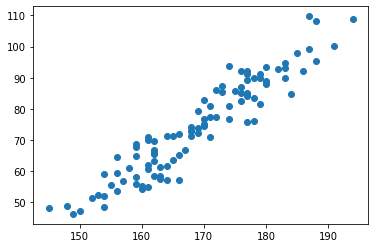

In [157]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


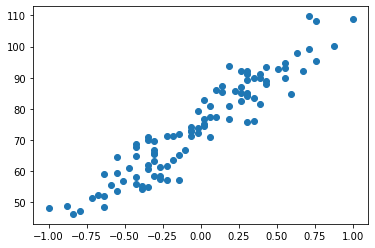

In [158]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

epoch:    0/1000. loss_train: 2715.63816697
epoch:  100/1000. loss_train: 448.00117490
epoch:  200/1000. loss_train: 121.64504985
epoch:  300/1000. loss_train: 62.23841810
epoch:  400/1000. loss_train: 43.46853431
epoch:  500/1000. loss_train: 33.51431891
epoch:  600/1000. loss_train: 27.06289654
epoch:  700/1000. loss_train: 22.67814641
epoch:  800/1000. loss_train: 19.66911393
epoch:  900/1000. loss_train: 17.60025114
epoch: 1000/1000. loss_train: 16.17727748
[[27.81095043]]
[[74.8450342]]


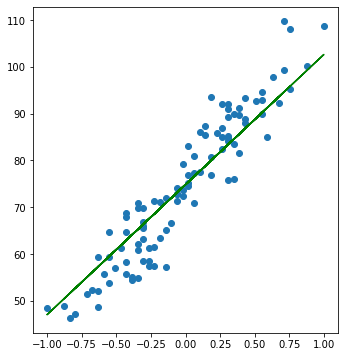

In [159]:
input_dim, output_dim = x.shape[1], y.shape[1]

# inicializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))
nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [160]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x = data[:, :-1]
y = data[:, -1].reshape(-1,1)

x.shape, y.shape

(25, 4)


((25, 3), (25, 1))

In [161]:
x.shape, y.shape

((25, 3), (25, 1))

In [162]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [1. 1. 1.]


In [163]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/5000. loss_train: 10007.20938346
epoch:  500/5000. loss_train: 3.35097928
epoch: 1000/5000. loss_train: 2.90633949
epoch: 1500/5000. loss_train: 2.87316508
epoch: 2000/5000. loss_train: 2.86944398
epoch: 2500/5000. loss_train: 2.86897364
epoch: 3000/5000. loss_train: 2.86891270
epoch: 3500/5000. loss_train: 2.86890476
epoch: 4000/5000. loss_train: 2.86890373
epoch: 4500/5000. loss_train: 2.86890359
epoch: 5000/5000. loss_train: 2.86890357
[[ 8.72089283 14.10522556 26.26733933]]
[[150.65173491]]


### Regressão Quadrática

(100, 1) (100, 1)


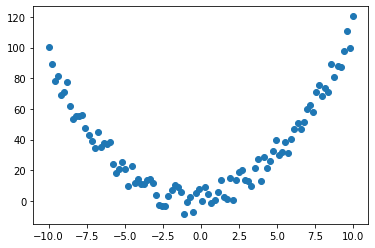

In [164]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [165]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000. loss_train: 7222.55167041
epoch:  500/5000. loss_train: 17.67770384
epoch: 1000/5000. loss_train: 15.49657963
epoch: 1500/5000. loss_train: 15.13963114
epoch: 2000/5000. loss_train: 15.06503868
epoch: 2500/5000. loss_train: 14.85623574
epoch: 3000/5000. loss_train: 14.80713707
epoch: 3500/5000. loss_train: 14.45482769
epoch: 4000/5000. loss_train: 14.35457929
epoch: 4500/5000. loss_train: 14.19650538
epoch: 5000/5000. loss_train: 14.01889495
[[-0.43694832]
 [ 0.28548317]
 [ 0.74586965]
 [-2.17078067]
 [-0.43002917]
 [-0.59464557]
 [ 0.02494181]
 [ 0.66534002]
 [-2.140209  ]
 [ 2.59304561]
 [ 2.23362728]
 [ 1.37856338]
 [-0.47174009]
 [-0.65290439]
 [-0.57700544]
 [ 0.05053536]
 [ 0.30374826]
 [ 0.06953535]
 [-0.67889964]
 [ 0.0426191 ]]
[[-0.7359832  -1.75252718 -1.36286769 -0.56435936 -0.7088824  -0.82608524
  -0.71668325 -0.66701606 -1.17386783 -1.49502738 -0.35004327 -2.1364717
  -0.9624456  -0.77375955 -0.58295233 -0.2591228  -0.70728528 -0.82184765
  -0.69980697 

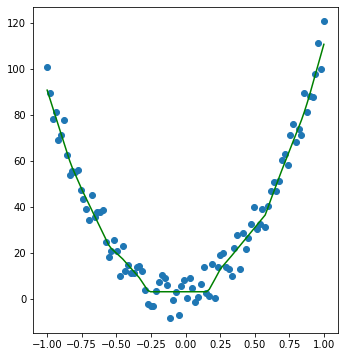

In [166]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

(100, 1) (100, 1)


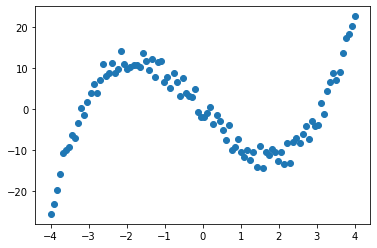

In [167]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [168]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000. loss_train: 55.20041681
epoch:  500/5000. loss_train: 10.03259033
epoch: 1000/5000. loss_train: 3.89176670
epoch: 1500/5000. loss_train: 2.57366757
epoch: 2000/5000. loss_train: 2.14990477
epoch: 2500/5000. loss_train: 1.94038108
epoch: 3000/5000. loss_train: 1.80259900
epoch: 3500/5000. loss_train: 1.70137026
epoch: 4000/5000. loss_train: 1.62297311
epoch: 4500/5000. loss_train: 1.56092837
epoch: 5000/5000. loss_train: 1.51129780


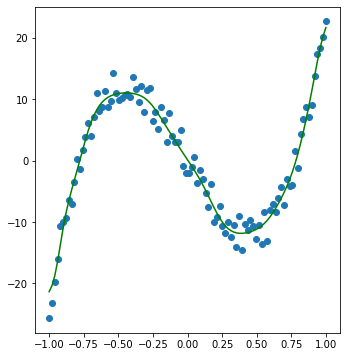

In [169]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


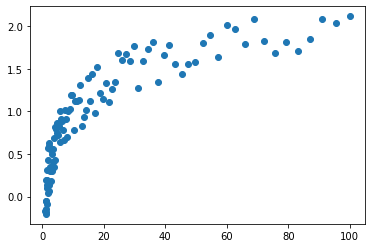

In [170]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [171]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/10000. loss_train: 1.08939699
epoch:  500/10000. loss_train: 0.07014645
epoch: 1000/10000. loss_train: 0.05099274
epoch: 1500/10000. loss_train: 0.04046118
epoch: 2000/10000. loss_train: 0.03320567
epoch: 2500/10000. loss_train: 0.02771059
epoch: 3000/10000. loss_train: 0.02382365
epoch: 3500/10000. loss_train: 0.02146103
epoch: 4000/10000. loss_train: 0.02020430
epoch: 4500/10000. loss_train: 0.01954982
epoch: 5000/10000. loss_train: 0.01916630
epoch: 5500/10000. loss_train: 0.01889716
epoch: 6000/10000. loss_train: 0.01867985
epoch: 6500/10000. loss_train: 0.01849082
epoch: 7000/10000. loss_train: 0.01832091
epoch: 7500/10000. loss_train: 0.01816604
epoch: 8000/10000. loss_train: 0.01802395
epoch: 8500/10000. loss_train: 0.01789309
epoch: 9000/10000. loss_train: 0.01777226
epoch: 9500/10000. loss_train: 0.01766044
epoch: 10000/10000. loss_train: 0.01755672


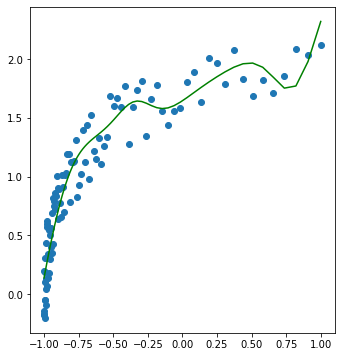

In [172]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=10000, verbose=500)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


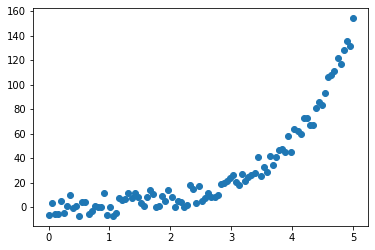

In [173]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [174]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000. loss_train: 1326.61974656
epoch:  500/5000. loss_train: 80.68721812
epoch: 1000/5000. loss_train: 32.85909385
epoch: 1500/5000. loss_train: 21.06174328
epoch: 2000/5000. loss_train: 17.21837188
epoch: 2500/5000. loss_train: 15.70627907
epoch: 3000/5000. loss_train: 14.89376717
epoch: 3500/5000. loss_train: 14.38299779
epoch: 4000/5000. loss_train: 14.03680221
epoch: 4500/5000. loss_train: 13.78616030
epoch: 5000/5000. loss_train: 13.59231602


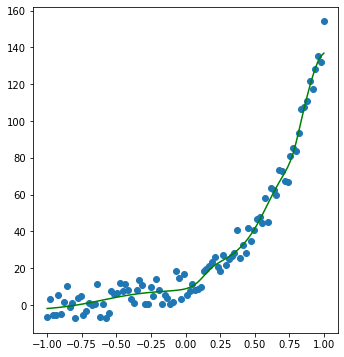

In [175]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


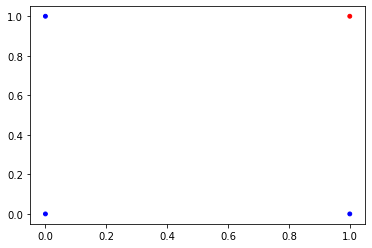

In [176]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 0.94810548
epoch: 1000/5000. loss_train: 0.47050470
epoch: 2000/5000. loss_train: 0.36046785
epoch: 3000/5000. loss_train: 0.29680123
epoch: 4000/5000. loss_train: 0.25465132
epoch: 5000/5000. loss_train: 0.22404320
Predições:
[[0.03298869]
 [0.23233429]
 [0.19598637]
 [0.68380141]]
Acurácia: 100.00%


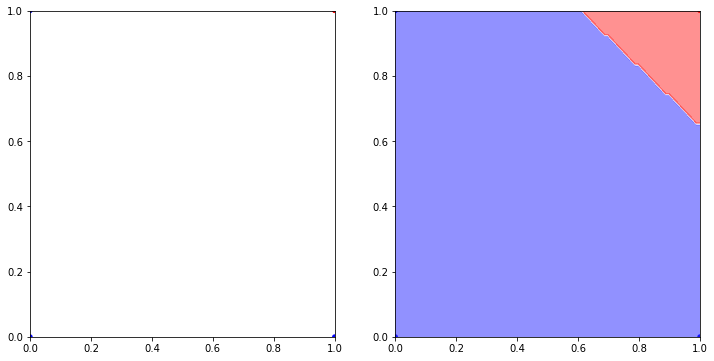

In [177]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-2)
#nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
#nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100 * accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

(4, 2) (4, 1)


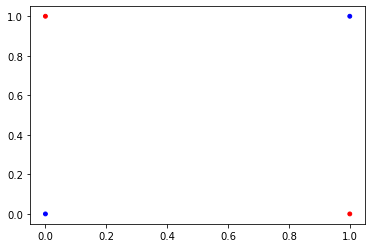

In [205]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 0.73633230
epoch: 1000/5000. loss_train: 0.29812486
epoch: 2000/5000. loss_train: 0.06661934
epoch: 3000/5000. loss_train: 0.02961306
epoch: 4000/5000. loss_train: 0.01791735
epoch: 5000/5000. loss_train: 0.01252699
Predições:
[[0.01092735]
 [0.987788  ]
 [0.98715964]
 [0.01381349]]
Acurácia: 100.00%


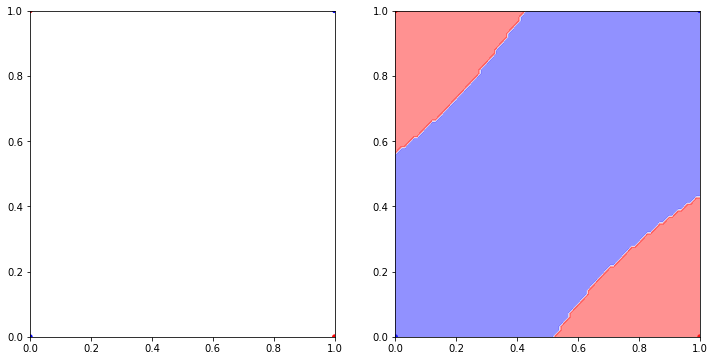

In [206]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=sigmoid))
#nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


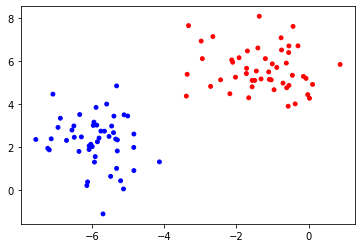

In [216]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 1.19280463
epoch: 1000/5000. loss_train: 0.00651494
epoch: 2000/5000. loss_train: 0.00439674
epoch: 3000/5000. loss_train: 0.00349312
epoch: 4000/5000. loss_train: 0.00295964
epoch: 5000/5000. loss_train: 0.00259630
Acurácia: 100.00%


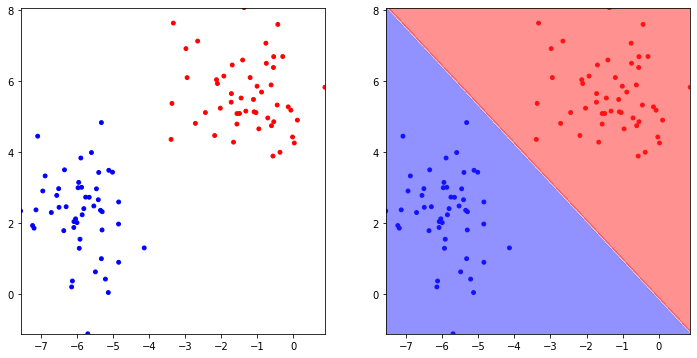

In [217]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=sigmoid))
#nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


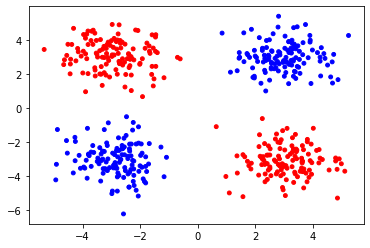

In [218]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 1.86524323
epoch: 1000/5000. loss_train: 0.04124815
epoch: 2000/5000. loss_train: 0.01957654
epoch: 3000/5000. loss_train: 0.01292885
epoch: 4000/5000. loss_train: 0.00972005
epoch: 5000/5000. loss_train: 0.00782851
Acurácia: 100.00%


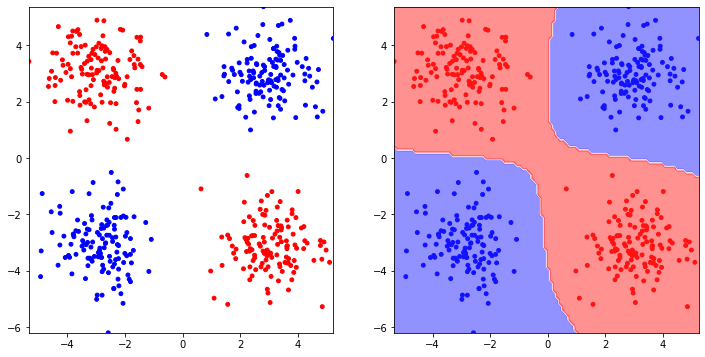

In [223]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=sigmoid))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


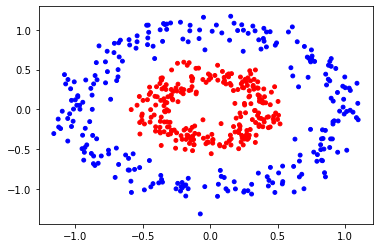

In [224]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 0.80525176
epoch: 1000/5000. loss_train: 0.43087279
epoch: 2000/5000. loss_train: 0.19983520
epoch: 3000/5000. loss_train: 0.10963850
epoch: 4000/5000. loss_train: 0.07340694
epoch: 5000/5000. loss_train: 0.05502101
Acurácia: 100.00%


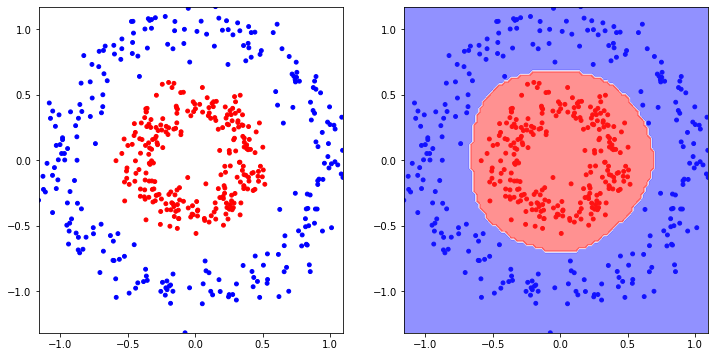

In [225]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=sigmoid))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


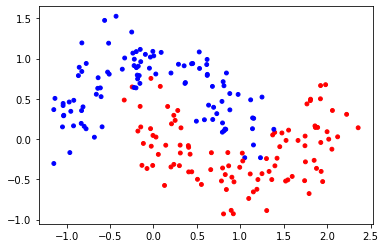

In [226]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 0.52436779
epoch: 1000/5000. loss_train: 0.18428116
epoch: 2000/5000. loss_train: 0.11505878
epoch: 3000/5000. loss_train: 0.09369803
epoch: 4000/5000. loss_train: 0.08368077
epoch: 5000/5000. loss_train: 0.07761287
Acurácia: 97.00%


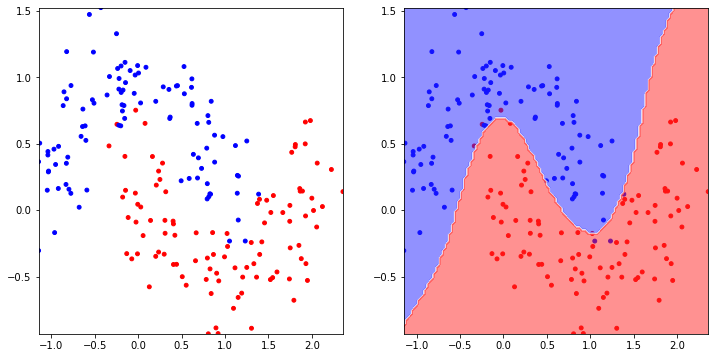

In [229]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

(200, 2) (200, 1)


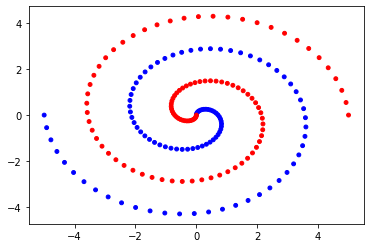

In [230]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 0.87519770
epoch: 1000/5000. loss_train: 0.08214212
epoch: 2000/5000. loss_train: 0.03691722
epoch: 3000/5000. loss_train: 0.02532824
epoch: 4000/5000. loss_train: 0.02003889
epoch: 5000/5000. loss_train: 0.01708807
Acurácia: 99.50%


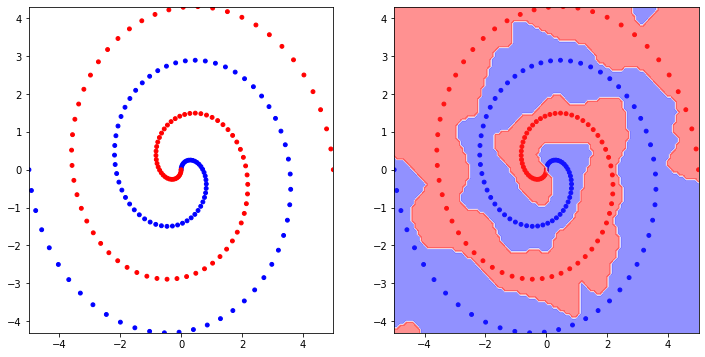

In [232]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


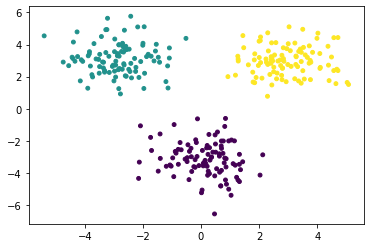

In [233]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [234]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


epoch:    0/5000. loss_train: 2.43958367
epoch: 1000/5000. loss_train: 0.00139628
epoch: 2000/5000. loss_train: 0.00064085
epoch: 3000/5000. loss_train: 0.00041129
epoch: 4000/5000. loss_train: 0.00030495
epoch: 5000/5000. loss_train: 0.00024333
Acurácia: 100.00%


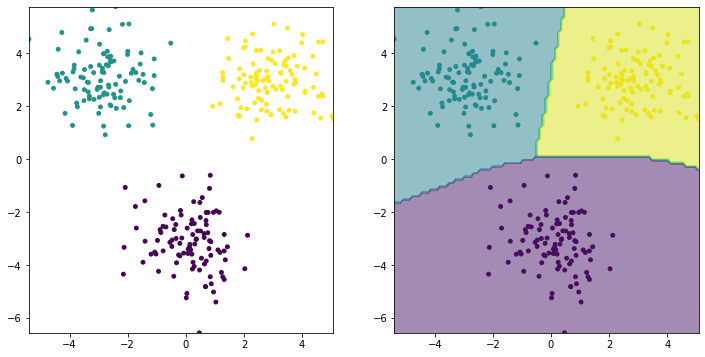

In [245]:
# DISCLAIMER: frameworks de deep learning usam o softmax como função de
#ativação na ultima camada e neg_log_likelihood como função de custo 

# exemplo do curso
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


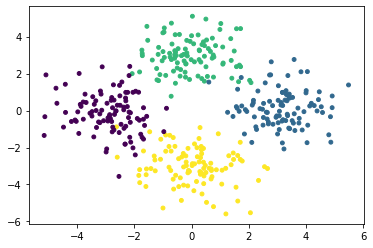

In [249]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [250]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


epoch:    0/5000. loss_train: 3.65798808
epoch: 1000/5000. loss_train: 0.06263146
epoch: 2000/5000. loss_train: 0.05932565
epoch: 3000/5000. loss_train: 0.05732327
epoch: 4000/5000. loss_train: 0.05581331
epoch: 5000/5000. loss_train: 0.05457853
Acurácia: 97.50%


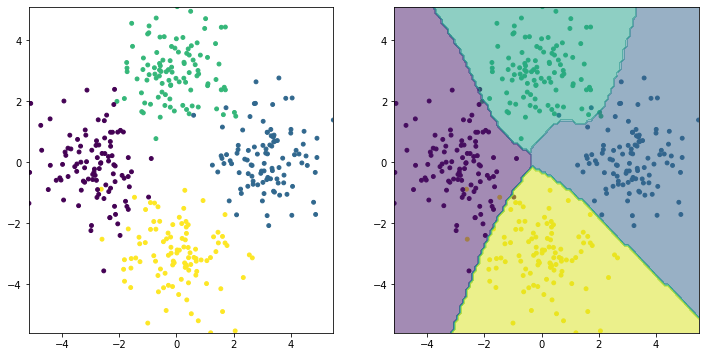

In [251]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=5000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


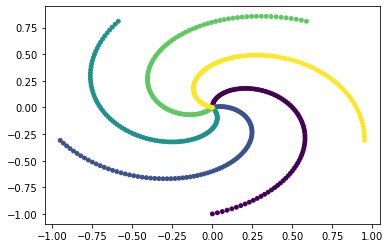

In [252]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [253]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/5000. loss_train: 11.44631834
epoch: 1000/5000. loss_train: 0.12717487
epoch: 2000/5000. loss_train: 0.06799734
epoch: 3000/5000. loss_train: 0.05104288
epoch: 4000/5000. loss_train: 0.04287869
epoch: 5000/5000. loss_train: 0.03796445
Acurácia: 99.20%


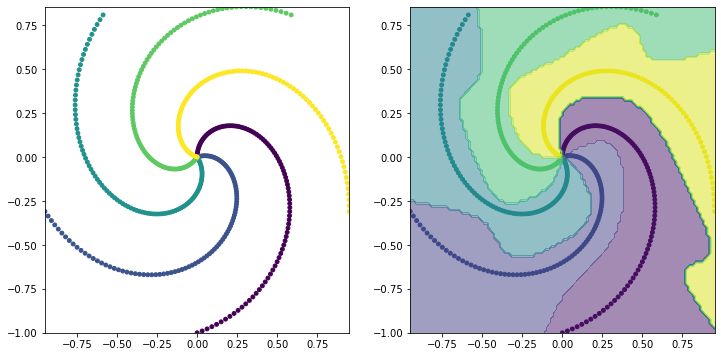

In [254]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=linear))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=5000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


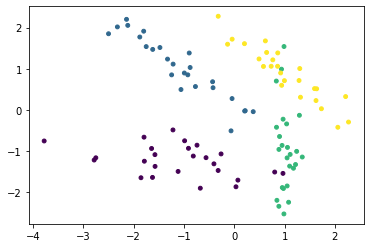

In [255]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [256]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


epoch:    0/5000. loss_train: 1.62237137
epoch: 1000/5000. loss_train: 0.06852831
epoch: 2000/5000. loss_train: 0.05574759
epoch: 3000/5000. loss_train: 0.04834016
epoch: 4000/5000. loss_train: 0.04013603
epoch: 5000/5000. loss_train: 0.03195010
Acurácia: 98.00%


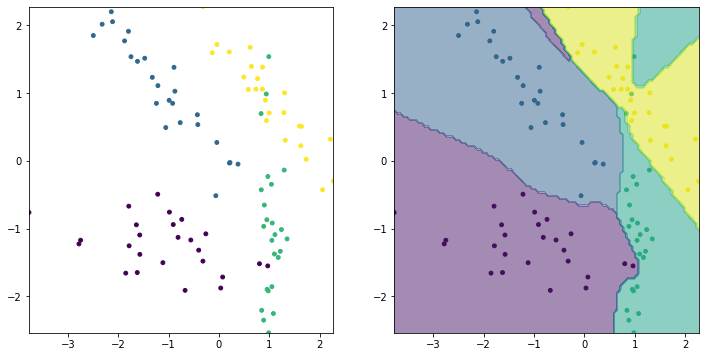

In [257]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=linear))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=5000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


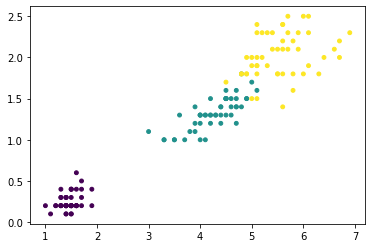

In [261]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [262]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


epoch:    0/5000. loss_train: 2.01319372
epoch: 1000/5000. loss_train: 0.30408682
epoch: 2000/5000. loss_train: 0.23298764
epoch: 3000/5000. loss_train: 0.19739647
epoch: 4000/5000. loss_train: 0.17534202
epoch: 5000/5000. loss_train: 0.16015276
Acurácia: 96.67%


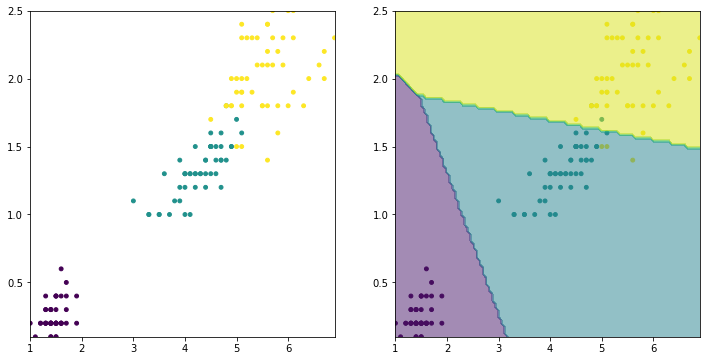

In [263]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=5000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

# [Link para o Questionário](https://docs.google.com/forms/d/e/1FAIpQLSf1B3JKsPPPc1oYD_3FyX4UvNLpcXnTW2I177A_WE0_B56Elw/viewform?usp=sf_link)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)